In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [3]:
train = pd.read_csv("train.csv")
# Drop the null columns where all values are null
test = pd.read_csv("test.csv")
# Drop the null rows
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
import re

test_str = train.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [5]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(train)
test = process_text(test)

In [7]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

print(train.shape, test.shape)

(7613, 18) (3263, 17)


In [8]:
from nltk import FreqDist, word_tokenize

# Make a set of stop words
stopwords = set(STOPWORDS)
# more_stopwords = {'https', 'amp'}
# stopwords = stopwords.union(more_stopwords

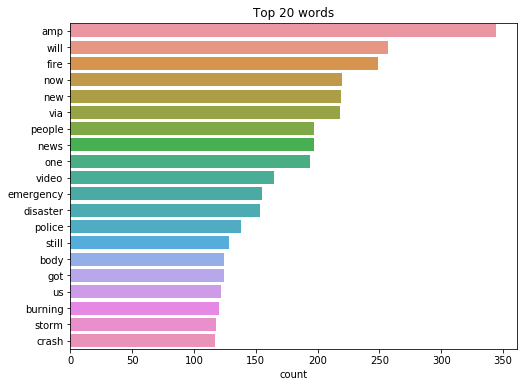

In [9]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

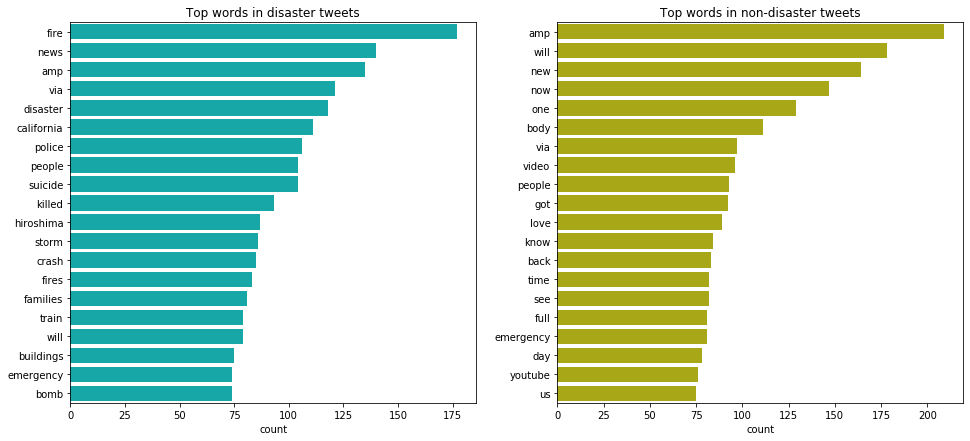

In [10]:
plt.figure(figsize=(16,7))
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(top20_d['count'], top20_d.index, color='c')
plt.title('Top words in disaster tweets')
plt.subplot(122)
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(top20_nd['count'], top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()

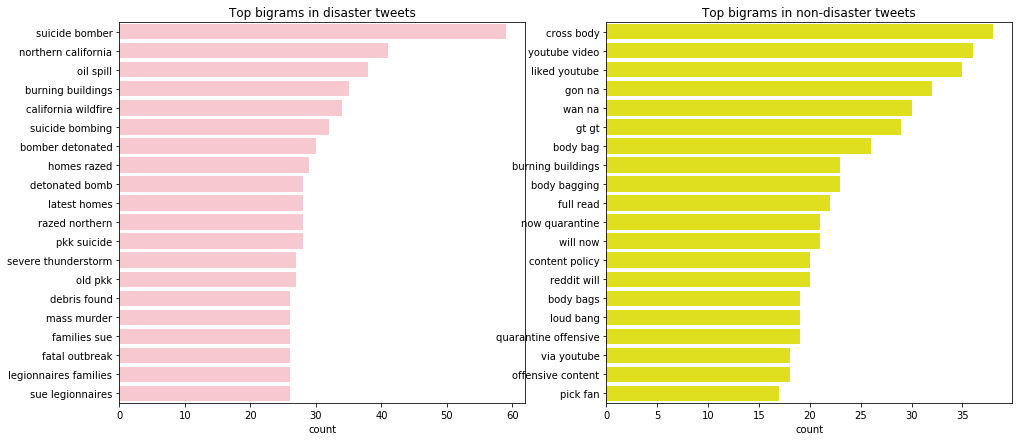

In [11]:
from nltk import bigrams

plt.figure(figsize=(16,7))
plt.subplot(121)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='pink')
plt.title('Top bigrams in disaster tweets')
plt.subplot(122)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20], color='yellow')
plt.title('Top bigrams in non-disaster tweets')
plt.show()

In [16]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features],train['target'])

train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train['text_clean'])
text_vec_test = vec_text.transform(test['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1691)


In [19]:
train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1842) (3263, 1841)


In [45]:
train

,id,keyword,location,text,target,text_clean,hashtags,mentions,links,text_len,...,û_,ûª,ûªs,ûªt,ûªve,ûï,ûïwhen,ûïwhen saw,ûò,ûó
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no,69,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no,38,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no,133,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no,64,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no,87,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#RockyFire Update => California Hwy. 20 closed...,RockyFire CAfire wildfires,no,no,110,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,#flood #disaster Heavy rain causes flash flood...,flood disaster,no,no,95,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,I'm on top of the hill and I can see a fire in...,no,no,no,59,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,There's an emergency evacuation happening now ...,no,no,no,79,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,I'm afraid that the tornado is coming to our a...,no,no,no,52,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [24]:
from sklearn.linear_model import LogisticRegression

features_to_drop = ['id', 'keyword','location','text','text_clean', 'hashtags', 'mentions','links']

X_train = train.drop(columns = features_to_drop + ['target'])
X_test = test.drop(columns = features_to_drop)
y_train = train.target



In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Columns: 1833 entries, text_len to ûó
dtypes: float64(1694), int64(139)
memory usage: 106.5 MB


In [38]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from C:\Users\floPe\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\floPe\AppData\Local\Temp\tmpdb1amnbj
  JVM stdout: C:\Users\floPe\AppData\Local\Temp\tmpdb1amnbj\h2o_floPe_started_from_python.out
  JVM stderr: C:\Users\floPe\AppData\Local\Temp\tmpdb1amnbj\h2o_floPe_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,"7 days, 2 hours and 52 minutes"
H2O cluster name:,H2O_from_python_floPe_31l90h
H2O cluster total nodes:,1
H2O cluster free memory:,1.982 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [46]:
htrain = h2o.H2OFrame(train)
htest = h2o.H2OFrame(train)

UnicodeEncodeError: 'charmap' codec can't encode character '\x89' in position 46: character maps to <undefined>

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=50, activation='relu', input_dim=1833))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [33]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train,
    y_train,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [35]:
model_loss, model_accuracy = model.evaluate(
    X_test, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

NameError: name 'y_test' is not defined

In [ ]:
lr = LogisticRegression(solver='liblinear', random_state=777) # Other solvers have failure to converge problem
lr.fit(X_train, y_train)
y_test = lr.predict(X_test)

submit = sub_sample.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)